# An implementation of Adaptive Bayesian Neural Networks (ABNN) for a basic CNN image classifier on CIFAR-10 dataset

## Import libraries

In [ ]:
!pip install netcal

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import time
import numpy as np
from torchsummary import summary
from torch.nn.functional import softmax
import torch.nn.functional as F
import netcal.metrics as metrics
from netcal.metrics import ECE
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, roc_curve
import sys
import os

# Get the current working directory of the notebook
current_dir = os.path.dirname(os.path.abspath('__file__'))

# Add the ABNN and 'Simple CNN Demo' directories to the Python path
abnn_dir = os.path.abspath(os.path.join(current_dir, './MakeMe-BNN/ABNN'))
if abnn_dir not in sys.path:
    sys.path.insert(0, abnn_dir)
demo_dir = os.path.abspath(os.path.join(current_dir, './MakeMe-BNN/Models/Simple CNN Demo'))
if demo_dir not in sys.path:
    sys.path.insert(0, demo_dir)

# Now import the necessary modules
from Simple_CNN import Net
from ABNN import BNL, CustomMAPLoss, replace_normalization_layers
from ABNN_Metrics import (
    calculate_accuracy, calculate_uncertainty, calculate_nll, calculate_ece,
    calculate_aupr, calculate_auc, calculate_fpr95, count_parameters,
    predict_with_uncertainty, plot_uncertainty
)

# Set the start method to 'spawn'
import multiprocessing
multiprocessing.set_start_method('spawn', force=True)

##  Train the base model and save the weights

### Load and Augment CIFAR-10

Similar to the paper, I only use Horizontal Flip for data augmentation

In [ ]:
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 68488387.16it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Define the base CNN model

In [ ]:
net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (bn4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# Print the summary of the model
summary(net, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
       BatchNorm2d-5           [-1, 64, 16, 16]             128
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
       BatchNorm2d-8            [-1, 128, 8, 8]             256
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Linear-10                  [-1, 256]         524,544
      BatchNorm1d-11                  [-1, 256]             512
           Linear-12                  [-1, 128]          32,896
      BatchNorm1d-13                  [-1, 128]             256
           Linear-14                   

### Train the base CNN model

For the training of our base model, I use standard image classification methods: standard cross-entropy loss and SGD

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

In [ ]:
# Timing the training process
start_time = time.time()

# Training
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 3000 == 2999:
            print(f'[epoch {epoch + 1}, mini-batch {i + 1:5d}] loss: {running_loss / 3000:.6f}')
            running_loss = 0.0
end_time = time.time()

print('Finished Training')
print(f'Time taken to train the model: {end_time - start_time:.2f} seconds')

[epoch 1, mini-batch  3000] loss: 1.984930
[epoch 1, mini-batch  6000] loss: 1.762789
[epoch 1, mini-batch  9000] loss: 1.646787
[epoch 1, mini-batch 12000] loss: 1.572071
[epoch 2, mini-batch  3000] loss: 1.482042
[epoch 2, mini-batch  6000] loss: 1.450515
[epoch 2, mini-batch  9000] loss: 1.399862
[epoch 2, mini-batch 12000] loss: 1.387563
[epoch 3, mini-batch  3000] loss: 1.352353
[epoch 3, mini-batch  6000] loss: 1.369324
[epoch 3, mini-batch  9000] loss: 1.362655
[epoch 3, mini-batch 12000] loss: 1.342339
[epoch 4, mini-batch  3000] loss: 1.316722
[epoch 4, mini-batch  6000] loss: 1.328776
[epoch 4, mini-batch  9000] loss: 1.305333
[epoch 4, mini-batch 12000] loss: 1.322257
[epoch 5, mini-batch  3000] loss: 1.295863
[epoch 5, mini-batch  6000] loss: 1.305171
[epoch 5, mini-batch  9000] loss: 1.289195
[epoch 5, mini-batch 12000] loss: 1.316605
[epoch 6, mini-batch  3000] loss: 1.269389
[epoch 6, mini-batch  6000] loss: 1.284552
[epoch 6, mini-batch  9000] loss: 1.278416
[epoch 6, m

### Test and save the model's weights

In [ ]:
accuracy = calculate_accuracy(testloader, net)

Accuracy of the network on the test images: 67.68%


In [ ]:
# Save the trained model weights
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)
print('Saved the model weights')

Saved the model weights


## Train the ABNN version

### Define the CNN's ABNN version

In [ ]:
original_model_path = 'Simple_CNN.py' # The path of original DNN
new_model_name = 'ABNNNet'        # The name of the new model
save_new_model='ABNNNet.py'       # The file to save the new model
replace_normalization_layers(original_model_path, new_model_name, save_new_model)

from ABNNNet import ABNNNet
abnnnet = ABNNNet()
print(abnnnet)

Modified model saved to ABNNNet.py
ABNNNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BNL()
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BNL()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BNL()
  (fc1): Linear(in_features=2048, out_features=256, bias=True)
  (bn4): BNL()
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (bn5): BNL()
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [ ]:
# Print the summary of the model
summary(abnnnet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
               BNL-2           [-1, 32, 32, 32]               0
         MaxPool2d-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 64, 16, 16]          18,496
               BNL-5           [-1, 64, 16, 16]               0
         MaxPool2d-6             [-1, 64, 8, 8]               0
            Conv2d-7            [-1, 128, 8, 8]          73,856
               BNL-8            [-1, 128, 8, 8]               0
         MaxPool2d-9            [-1, 128, 4, 4]               0
           Linear-10                  [-1, 256]         524,544
              BNL-11                  [-1, 256]               0
           Linear-12                  [-1, 128]          32,896
              BNL-13                  [-1, 128]               0
           Linear-14                   

### Training the new model

In [ ]:
criterion = CustomMAPLoss(num_classes=10)
optimizer = optim.SGD(filter(lambda p: p.requires_grad, abnnnet.parameters()), lr=0.0057, momentum=0.9, weight_decay=5e-4)

In [ ]:
PATH = './cifar_net.pth'
abnnnet.load_state_dict(torch.load(PATH), strict=False)
print('Model weights loaded.')
print('Start Training')
# Timing the training process
start_time = time.time()

for epoch in range(3):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = abnnnet(inputs)
        loss = criterion(outputs, labels, abnnnet)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 3000 == 2999:
            print(f'[epoch {epoch + 1}, mini-batch {i + 1:5d}] loss: {running_loss / 3000:.6f}')
            running_loss = 0.0
end_time = time.time()

print('Finished Training')
print(f'Time taken to train the model: {end_time - start_time:.2f} seconds')

Model weights loaded.
Start Training
[epoch 1, mini-batch  3000] loss: 2.177202
[epoch 1, mini-batch  6000] loss: 2.085917
[epoch 1, mini-batch  9000] loss: 2.028962
[epoch 1, mini-batch 12000] loss: 2.004952
[epoch 2, mini-batch  3000] loss: 1.998862
[epoch 2, mini-batch  6000] loss: 1.990415
[epoch 2, mini-batch  9000] loss: 1.989050
[epoch 2, mini-batch 12000] loss: 1.992181
[epoch 3, mini-batch  3000] loss: 1.961534
[epoch 3, mini-batch  6000] loss: 1.979561
[epoch 3, mini-batch  9000] loss: 1.976655
[epoch 3, mini-batch 12000] loss: 1.943315
Finished Training
Time taken to train the model: 1300.32 seconds


In [ ]:
# Save the trained model weights
PATH = './cifar_abnnnet.pth'
torch.save(abnnnet.state_dict(), PATH)
print('Saved the model weights')

Saved the model weights


## Calculate the ABNN model's evaluation metrics according to the paper

### Accuracy (Acc)

In [ ]:
acc = calculate_accuracy(testloader, abnnnet)

Accuracy of the network on the test images: 25.79%


### Uncertainty

In [ ]:
uncertainties = calculate_uncertainty(testloader, abnnnet)

Average variance for class 0: 0.004643
Average variance for class 1: 0.011140
Average variance for class 2: 0.005432
Average variance for class 3: 0.002364
Average variance for class 4: 0.002836
Average variance for class 5: 0.006568
Average variance for class 6: 0.007841
Average variance for class 7: 0.003800
Average variance for class 8: 0.004747
Average variance for class 9: 0.005300


### Negative Log-Likelihood (NLL)

In [ ]:
nll = calculate_nll(testloader, abnnnet, criterion)

Negative Log-Likelihood: 2.9404


### Expected Calibration Error (ECE)

In [ ]:
ece = calculate_ece(testloader, abnnnet)

Expected Calibration Error (ECE): 0.0210


### Area Under the Precision-Recall Curve (AUPR)

In [ ]:
aupr = calculate_aupr(testloader, abnnnet)

Class 0: AUPR = 0.2546
Class 1: AUPR = 0.3858
Class 2: AUPR = 0.1805
Class 3: AUPR = 0.1765
Class 4: AUPR = 0.1875
Class 5: AUPR = 0.2137
Class 6: AUPR = 0.2512
Class 7: AUPR = 0.2937
Class 8: AUPR = 0.3469
Class 9: AUPR = 0.2603
Mean AUPR: 0.2551


### Area Under the ROC Curve (AUC)

In [ ]:
auc = calculate_auc(testloader, abnnnet)

Class 0: AUC = 0.7381
Class 1: AUC = 0.8125
Class 2: AUC = 0.6652
Class 3: AUC = 0.6576
Class 4: AUC = 0.6741
Class 5: AUC = 0.6922
Class 6: AUC = 0.7421
Class 7: AUC = 0.7541
Class 8: AUC = 0.7860
Class 9: AUC = 0.7412
Mean AUC: 0.7263


### False Positive Rate at 95% True Positive Rate (FPR95)

In [ ]:
fpr_95_recall = calculate_fpr95(testloader, abnnnet)

Class 0: FPR at 95% Recall = 0.7611
Class 1: FPR at 95% Recall = 0.6862
Class 2: FPR at 95% Recall = 0.8462
Class 3: FPR at 95% Recall = 0.8402
Class 4: FPR at 95% Recall = 0.8063
Class 5: FPR at 95% Recall = 0.8379
Class 6: FPR at 95% Recall = 0.7798
Class 7: FPR at 95% Recall = 0.7908
Class 8: FPR at 95% Recall = 0.6724
Class 9: FPR at 95% Recall = 0.8111
Mean FPR at 95% Recall: 0.7832


### Number of Parameters ($\Delta$Param)

In [ ]:
params = count_parameters(abnnnet)

Number of Parameters: 654410


## Train and test multiple models similar to the paper's approach to improve performance

In [ ]:
def train_abnn_models(num_models, trainloader, num_classes, num_epochs, pretrained_weights_path, save_dir):
    """
    Train multiple ABNN models and save their weights.

    Parameters:
    - num_models: Number of models to train.
    - trainloader: DataLoader for the training dataset.
    - num_classes: Number of classes in the dataset.
    - num_epochs: Number of epochs to train each model.
    - pretrained_weights_path: Path to the pretrained weights.
    - save_dir: Directory to save the trained model weights.

    Returns:
    - models: List of state dictionaries of the trained models.
    """
    models = []
    criterion = CustomMAPLoss(num_classes)
    for model_idx in range(num_models):
        abnnnet = ABNNNet()
        PATH = pretrained_weights_path
        abnnnet.load_state_dict(torch.load(PATH), strict=False)
        optimizer = optim.SGD(abnnnet.parameters(), lr=0.001, momentum=0.9)
        for epoch in range(num_epochs):
            running_loss = 0.0
            for i, data in enumerate(trainloader, 0):
                inputs, labels = data
                optimizer.zero_grad()
                outputs = abnnnet(inputs)
                loss = criterion(outputs, labels, abnnnet)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                if i % 3000 == 2999:
                    print(f'Model {model_idx + 1} [epoch {epoch + 1}, mini-batch {i + 1:5d}] loss: {running_loss / 3000:.6f}')
                    running_loss = 0.0
        # Save the trained model weights
        model_path = f"{save_dir}/abnnnet_model_{model_idx + 1}.pth"
        torch.save(abnnnet.state_dict(), model_path)
        models.append(abnnnet.state_dict())
        print(f"Saved Model {model_idx + 1} weights to {model_path}")
    print('Finished Training')
    return models

save_dir = './trained_models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

start_time = time.time()

# Train multiple ABNN models
trained_models = train_abnn_models(
    num_models=3,  # We train 3 versions similar to the paper
    trainloader=trainloader,
    num_classes=10,
    num_epochs=3,
    pretrained_weights_path='./cifar_net.pth',
    save_dir='./trained_models'
)

end_time = time.time()
print(f'Time taken to train the models: {end_time - start_time:.2f} seconds')

Model 1 [epoch 1, mini-batch  3000] loss: 1.952117
Model 1 [epoch 1, mini-batch  6000] loss: 1.779411
Model 1 [epoch 1, mini-batch  9000] loss: 1.740775
Model 1 [epoch 1, mini-batch 12000] loss: 1.742160
Model 1 [epoch 2, mini-batch  3000] loss: 1.686947
Model 1 [epoch 2, mini-batch  6000] loss: 1.676896
Model 1 [epoch 2, mini-batch  9000] loss: 1.643096
Model 1 [epoch 2, mini-batch 12000] loss: 1.658442
Model 1 [epoch 3, mini-batch  3000] loss: 1.602314
Model 1 [epoch 3, mini-batch  6000] loss: 1.626193
Model 1 [epoch 3, mini-batch  9000] loss: 1.605556
Model 1 [epoch 3, mini-batch 12000] loss: 1.626692
Saved Model 1 weights to ./trained_models/abnnnet_model_1.pth
Model 2 [epoch 1, mini-batch  3000] loss: 1.969540
Model 2 [epoch 1, mini-batch  6000] loss: 1.818115
Model 2 [epoch 1, mini-batch  9000] loss: 1.702458
Model 2 [epoch 1, mini-batch 12000] loss: 1.737292
Model 2 [epoch 2, mini-batch  3000] loss: 1.696037
Model 2 [epoch 2, mini-batch  6000] loss: 1.688470
Model 2 [epoch 2, mi

In [ ]:
predictions, labels, predicted_classes = predict_with_uncertainty(ABNNNet, trained_models, testloader, num_samples=10, num_classes = 10)

Accuracy of the network on the test images: 26.54%
Class 0 variance: 0.041707
Class 1 variance: 0.046844
Class 2 variance: 0.038842
Class 3 variance: 0.035794
Class 4 variance: 0.039320
Class 5 variance: 0.039910
Class 6 variance: 0.037829
Class 7 variance: 0.039801
Class 8 variance: 0.041630
Class 9 variance: 0.044443


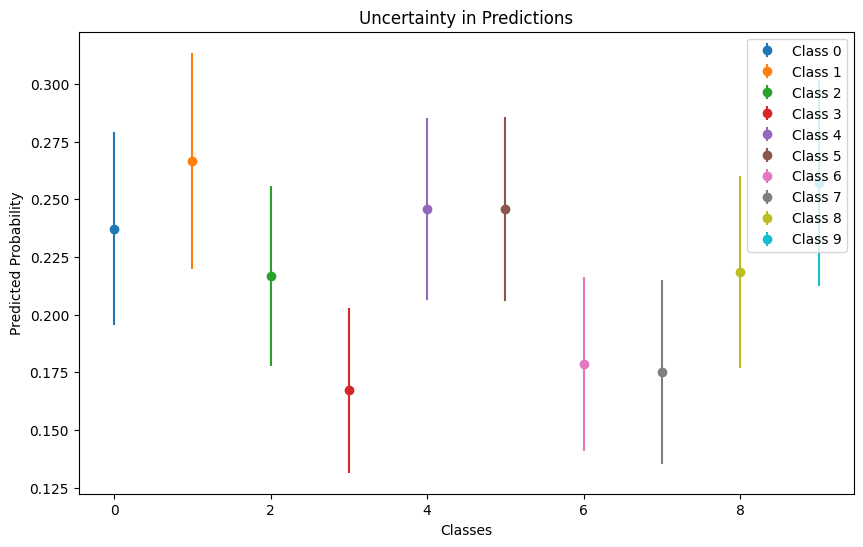

In [ ]:
plot_uncertainty(predictions, labels, num_classes=10)

## Download the generated outputs (for colab)

In [ ]:
# from google.colab import files
# files.download('/content/cifar_net.pth')
# files.download('/content/ABNNNet.py')
# files.download('/content/cifar_abnnnet.pth')
# files.download('/content/trained_models/abnnnet_model_1.pth')
# files.download('/content/trained_models/abnnnet_model_2.pth')
# files.download('/content/trained_models/abnnnet_model_3.pth')